In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv("../../data/processed/COEN498-691_HAR_dataset.csv", header=0, sep = ",")
df.head(10)

participant_id activity_id     timestamp     ax     ay     az
0             ZM     sitting  1.760380e+09 -0.005  0.850  0.477
1             ZM     sitting  1.760380e+09 -0.000  0.850  0.477
2             ZM     sitting  1.760380e+09  0.002  0.850  0.477
3             ZM     sitting  1.760380e+09 -0.008  0.850  0.483
4             ZM     sitting  1.760380e+09  0.006  0.852  0.480
5             ZM     sitting  1.760380e+09  0.001  0.851  0.477
6             ZM     sitting  1.760380e+09 -0.002  0.853  0.481
7             ZM     sitting  1.760380e+09  0.008  0.841  0.479
8             ZM     sitting  1.760380e+09 -0.005  0.851  0.484
9             ZM     sitting  1.760380e+09 -0.002  0.857  0.481

In [20]:
# Calculate the sampling frequency obtained from the timestamps
time_diffs = df['timestamp'].diff().dropna()
sampling_frequency = 1 / time_diffs.mean()
print(f"Sampling Frequency: {sampling_frequency:.2f} Hz")

Sampling Frequency: 10.34 Hz


In [21]:
tcol = "timestamp"  

# If your timestamps are in milliseconds (typical), convert to seconds
# If they are already in seconds, set this to 1.0
ts_unit = 1.0  # set to 0.001 if timestamps are in milliseconds

t = df[tcol].astype(float) * ts_unit
dt = np.diff(t)

print("samples:", len(t))
print("median dt (s):", np.median(dt))
print("mean dt (s):", np.mean(dt))
print("median sampling frequency (Hz):", 1.0 / np.median(dt))
print("mean sampling frequency (Hz):", 1.0 / np.mean(dt))
print("dt percentiles (ms):", np.percentile(dt*1000, [1,5,25,50,75,95,99]))

# Resample df to uniform time grid
fs_target = 25.0  # target sampling frequency in Hz
t_uniform = np.arange(t.iloc[0], t.iloc[-1], 1.0/fs_target)
df_resampled = pd.DataFrame({tcol: t_uniform})

# print stats about resampled data
print("samples:", len(t_uniform))
print("median dt (s):", np.median(np.diff(t_uniform)))
print("mean dt (s):", np.mean(np.diff(t_uniform)))
print("median sampling frequency (Hz):", 1.0 / np.median(np.diff(t_uniform)))
print("mean sampling frequency (Hz):", 1.0 / np.mean(np.diff(t_uniform)))
print("dt percentiles (ms):", np.percentile(np.diff(t_uniform)*1000, [1,5,25,50,75,95,99]))


samples: 64686
median dt (s): 0.039999961853027344
mean dt (s): 0.09673585083050273
median sampling frequency (Hz): 25.000023841880648
mean sampling frequency (Hz): 10.337429106321357
dt percentiles (ms): [35.33315659 39.66593742 39.99900818 39.99996185 40.00091553 40.00210762
 40.33493996]
samples: 156434
median dt (s): 0.039999961853027344
mean dt (s): 0.039999961853027344
median sampling frequency (Hz): 25.000023841880648
mean sampling frequency (Hz): 25.000023841880648
dt percentiles (ms): [39.99996185 39.99996185 39.99996185 39.99996185 39.99996185 39.99996185
 39.99996185]


In [ ]:
print(df_resampled.head(10))

In [8]:
# Keep only 120 seconds of data for each participant-activity pair
truncated_df = pd.DataFrame()
for participant_id in df['participant_id'].unique():
    for activity_id in df['activity_id'].unique():
        subset = df[(df['participant_id'] == participant_id) & (df['activity_id'] == activity_id)]
        if not subset.empty:
            start_time = subset['timestamp'].min()
            end_time = start_time + 120
            truncated_subset = subset[subset['timestamp'] <= end_time]
            truncated_df = pd.concat([truncated_df, truncated_subset], ignore_index=True)
truncated_df.head(10)

timestamp activity_id participant_id     ax     ay        az        gx  \
0  1.760380e+09     sitting             ZM -0.001  0.849  0.484333 -0.569667   
1  1.760380e+09     sitting             ZM -0.008  0.850  0.483000 -0.610000   
2  1.760380e+09     sitting             ZM  0.006  0.852  0.480000 -0.519000   
3  1.760380e+09     sitting             ZM  0.001  0.851  0.477000 -0.610000   
4  1.760380e+09     sitting             ZM -0.002  0.853  0.481000 -0.671000   
5  1.760380e+09     sitting             ZM  0.008  0.841  0.479000 -0.427000   
6  1.760380e+09     sitting             ZM -0.005  0.851  0.484000 -0.610000   
7  1.760380e+09     sitting             ZM -0.002  0.857  0.481000 -0.366000   
8  1.760380e+09     sitting             ZM  0.002  0.847  0.478000 -0.519000   
9  1.760380e+09     sitting             ZM -0.004  0.853  0.467000 -0.977000   

      gy        gz    mx         my    mz  
0 -0.305  0.305333  91.0  14.666667 -27.0  
1 -0.214  0.214000  90.0  15.000000 -28.0  
2 -0.580  0.183000  90.0  15.000000 -27.0  
3 -0.702  0.366000  91.0  14.000000 -28.0  
4  0.061  0.397000  90.0  14.000000 -29.0  
5 -0.275  0.244000  91.0  14.000000 -27.0  
6  0.671 -0.031000  91.0  14.000000 -27.0  
7  0.702  0.244000  91.0  14.000000 -28.0  
8 -0.061  0.061000  90.0  14.000000 -28.0  
9 -0.153 -0.122000  91.0  15.000000 -27.0

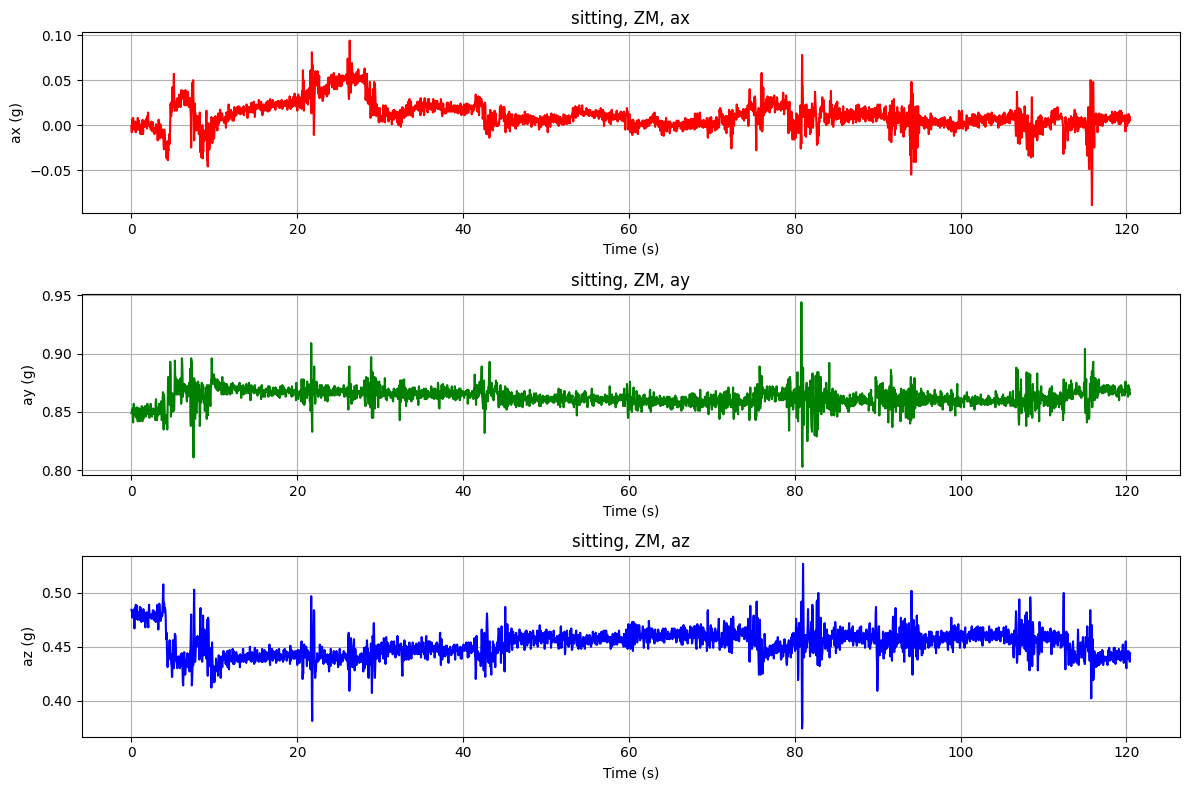

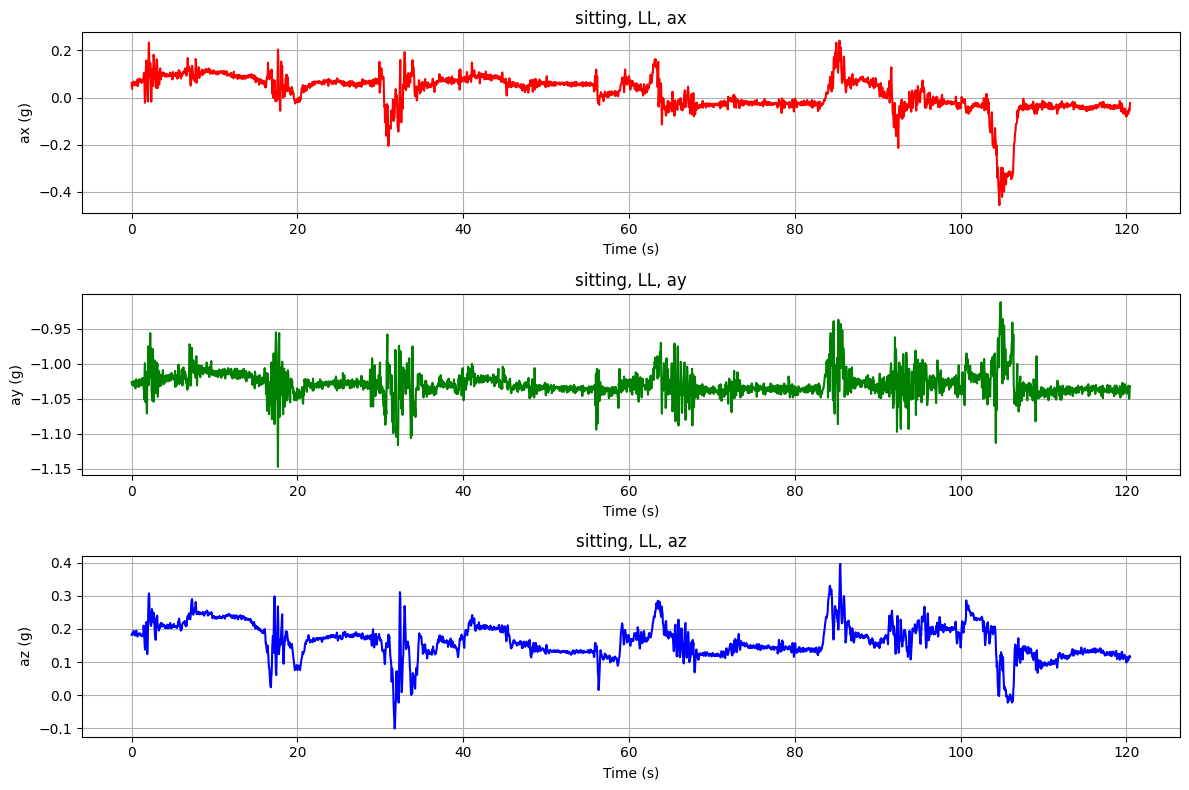

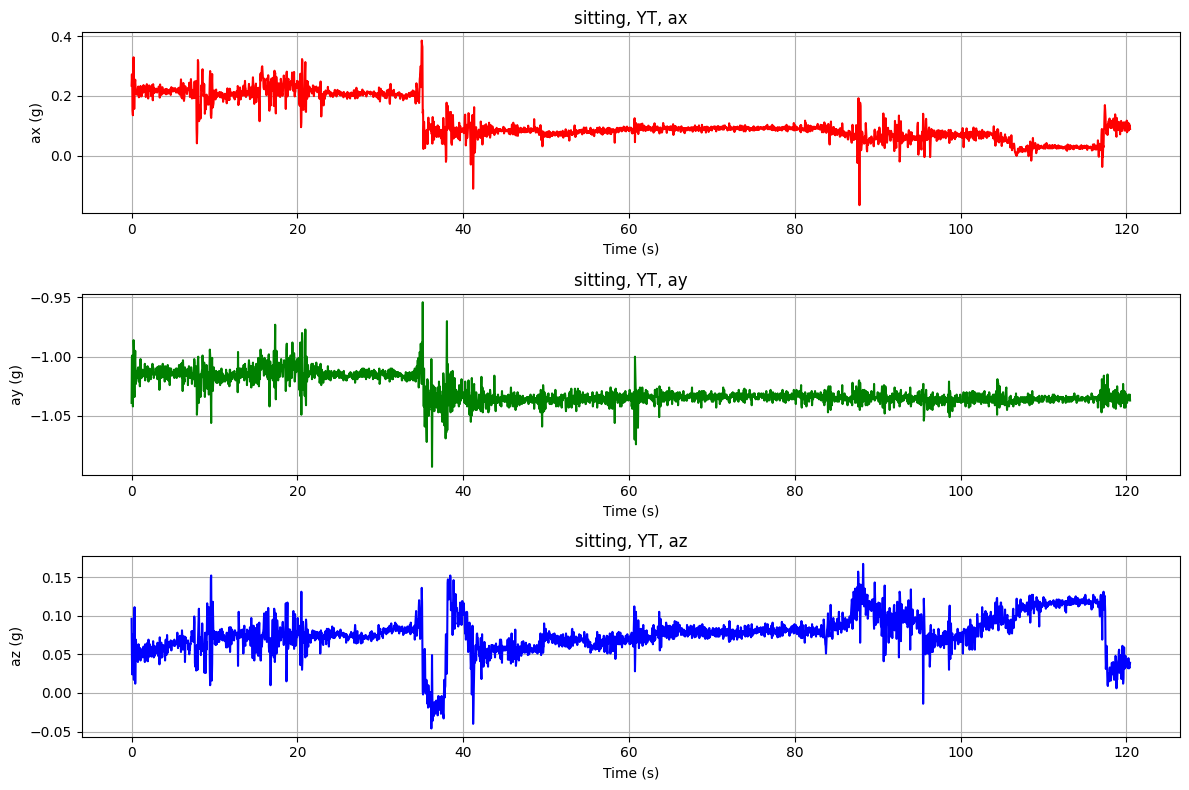

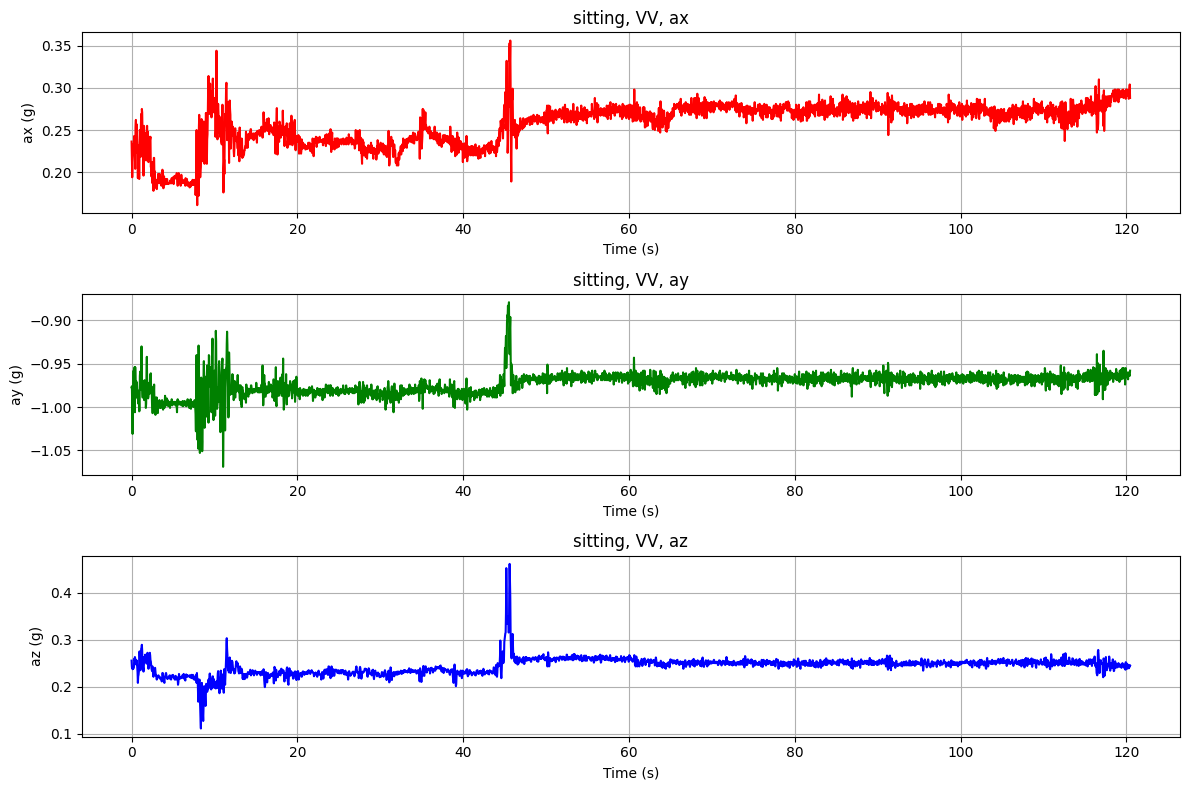

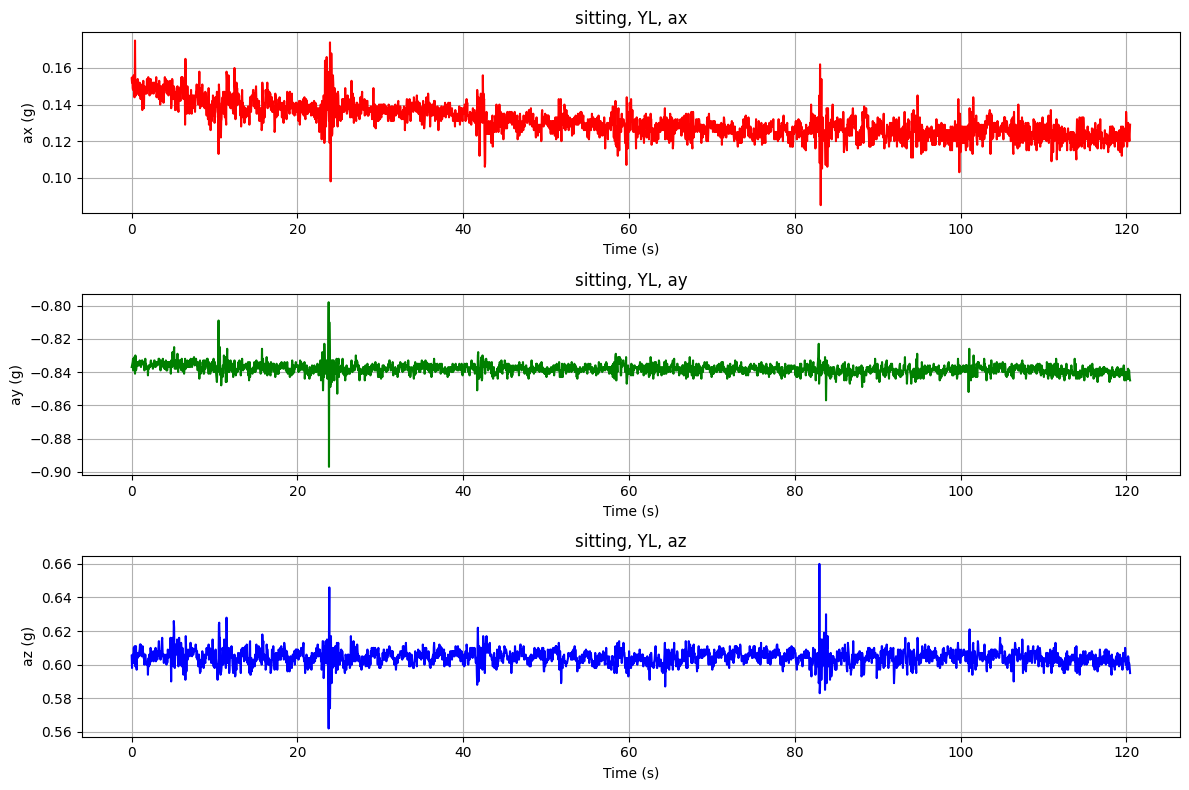

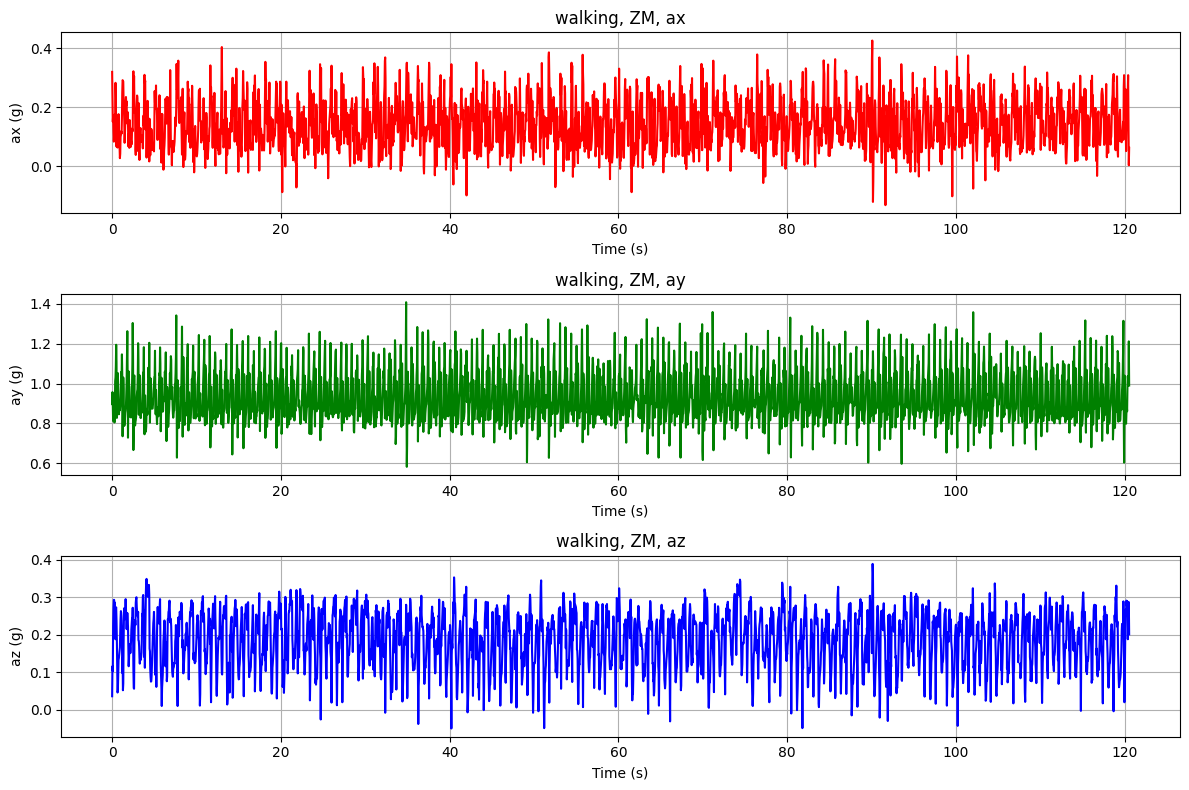

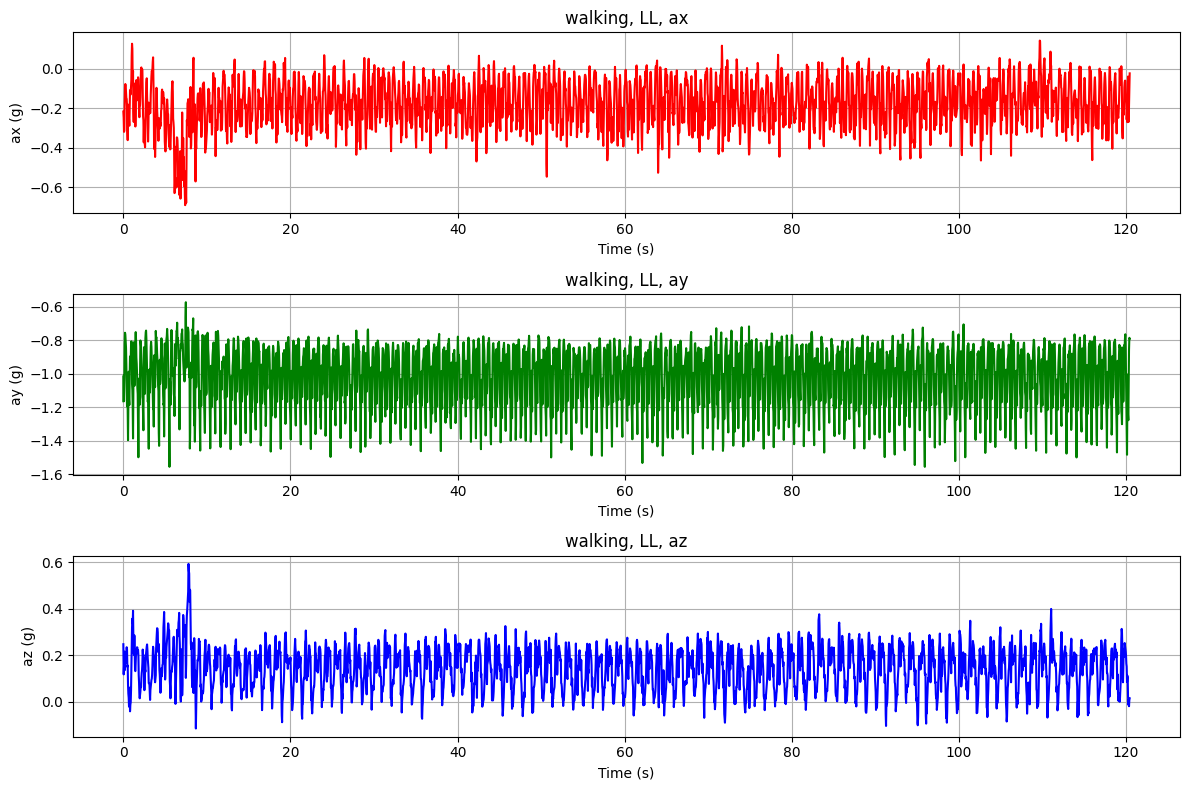

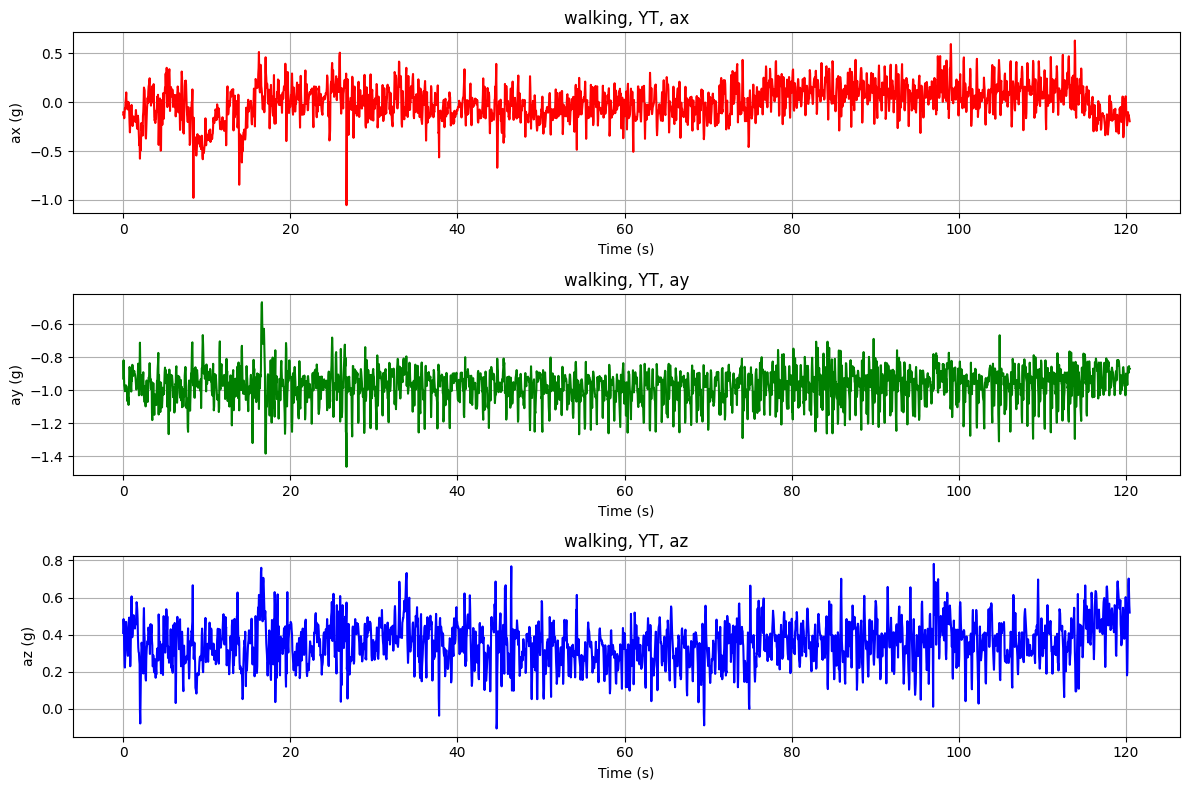

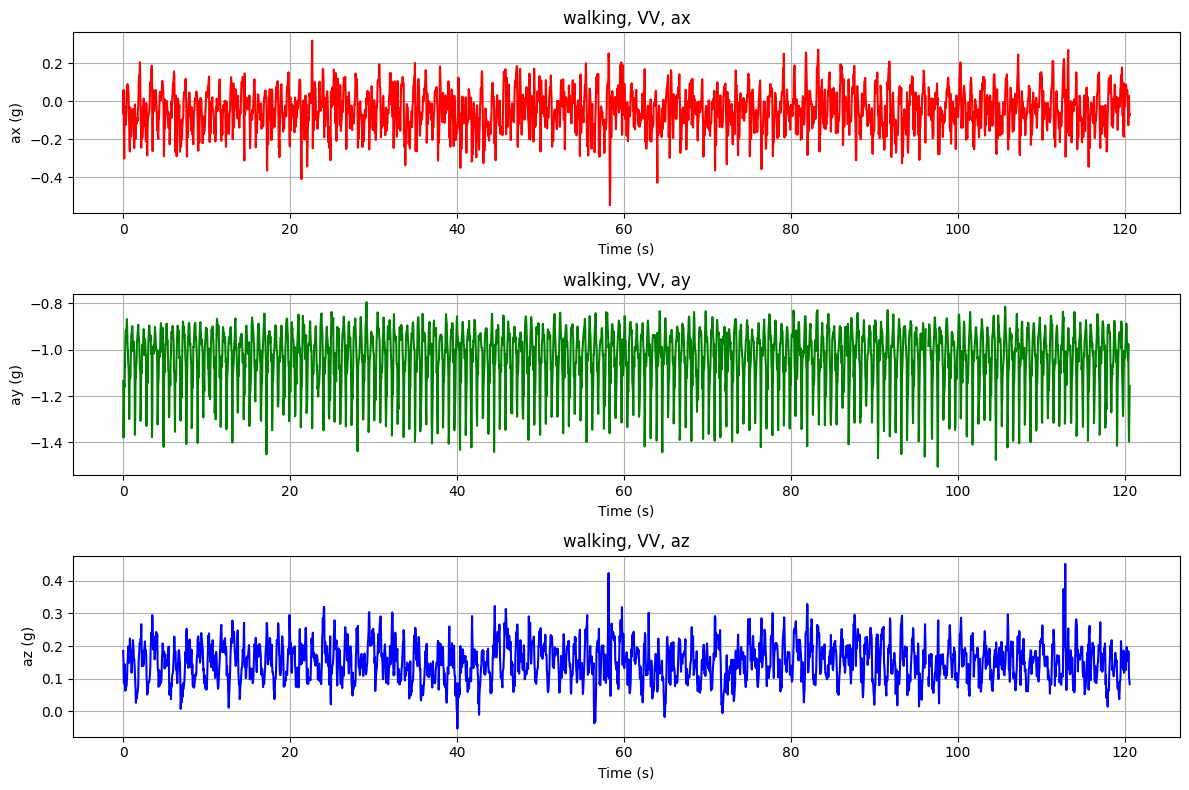

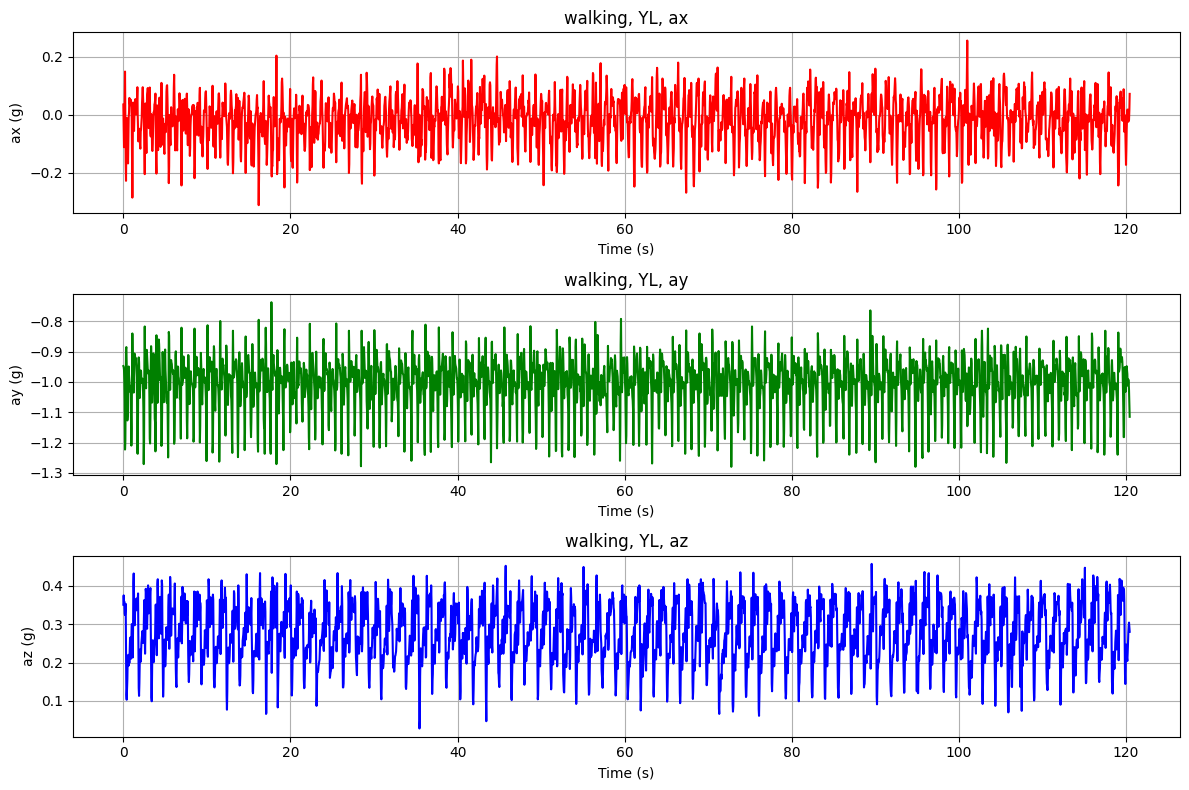

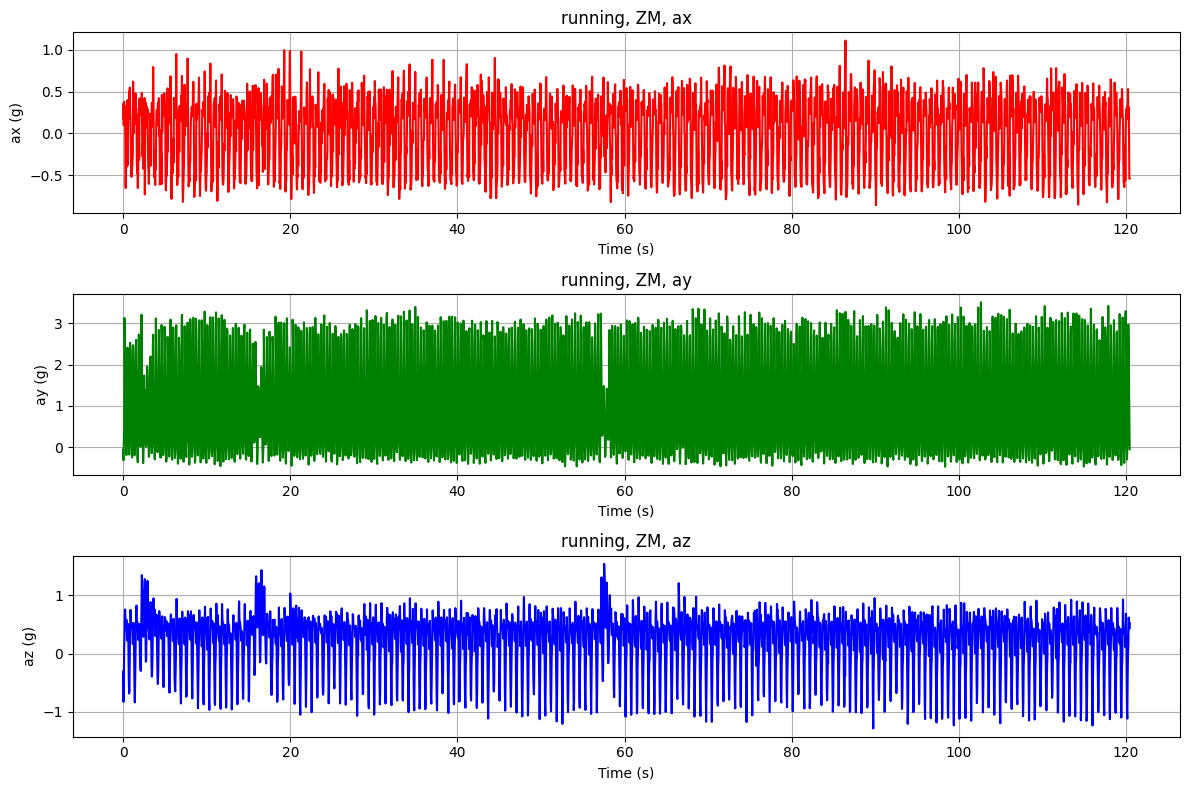

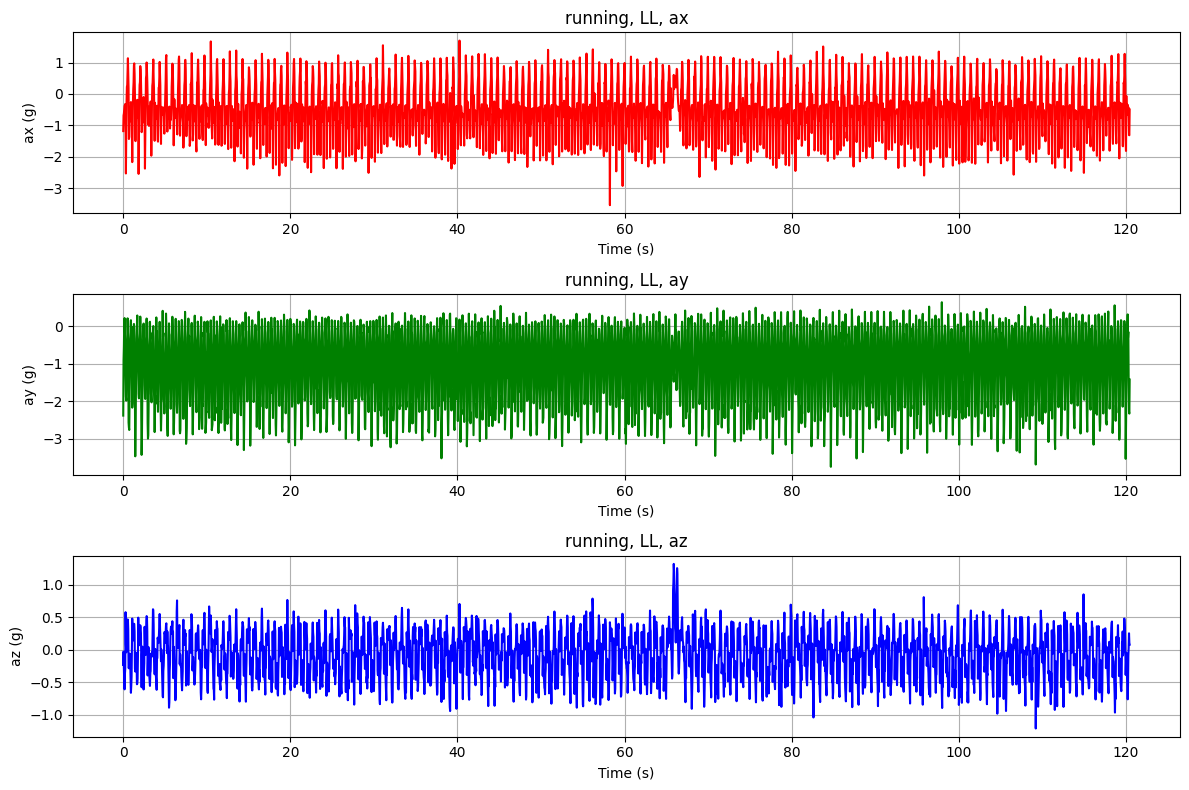

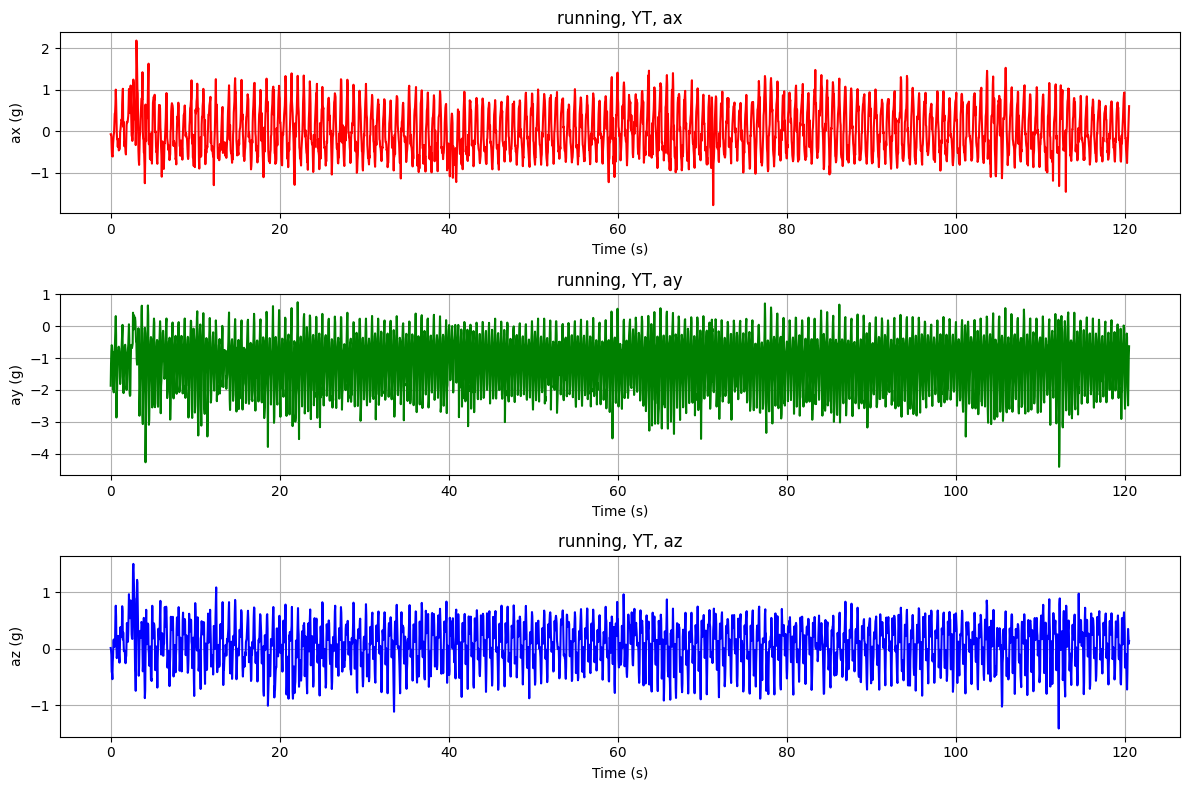

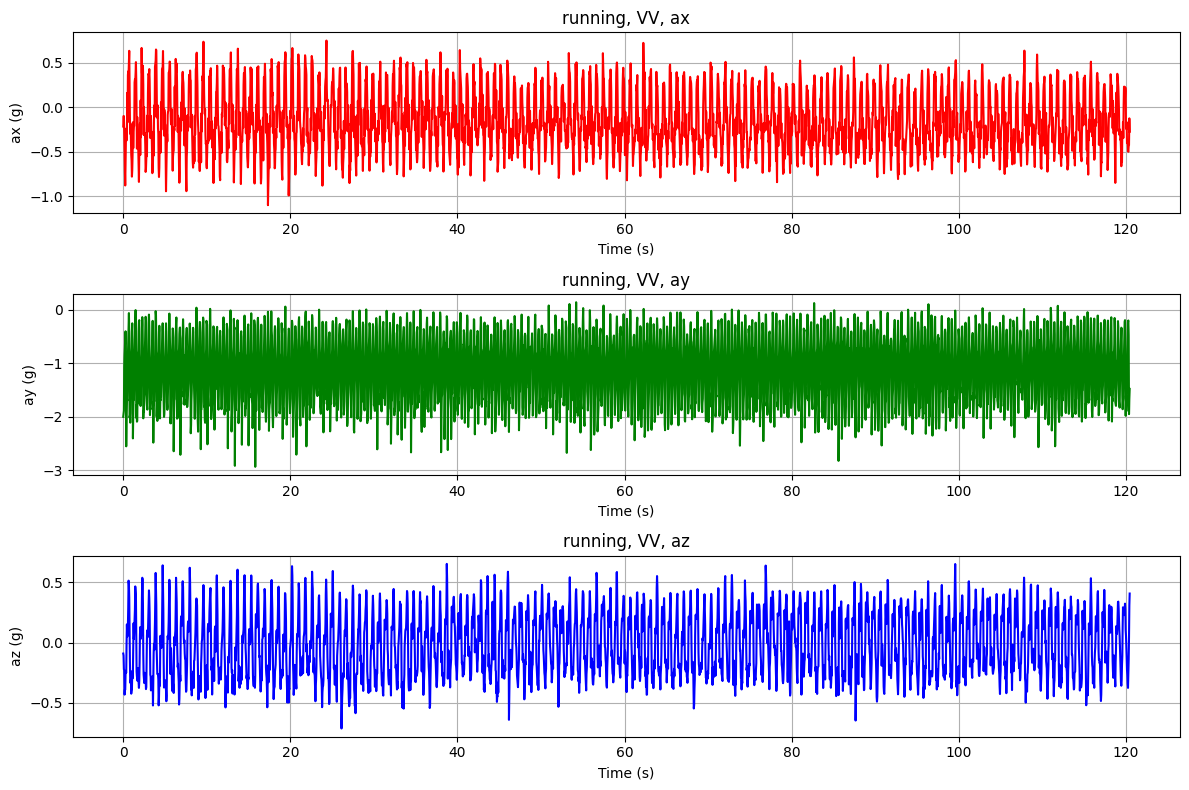

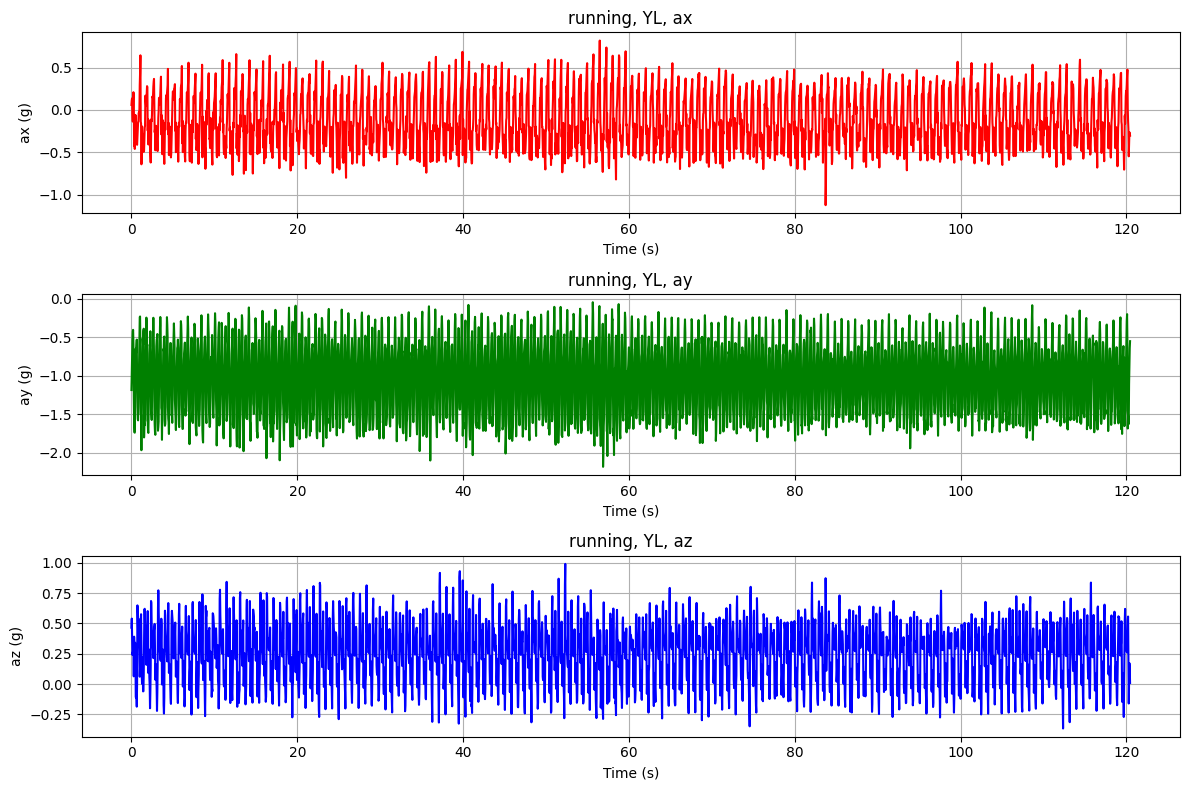

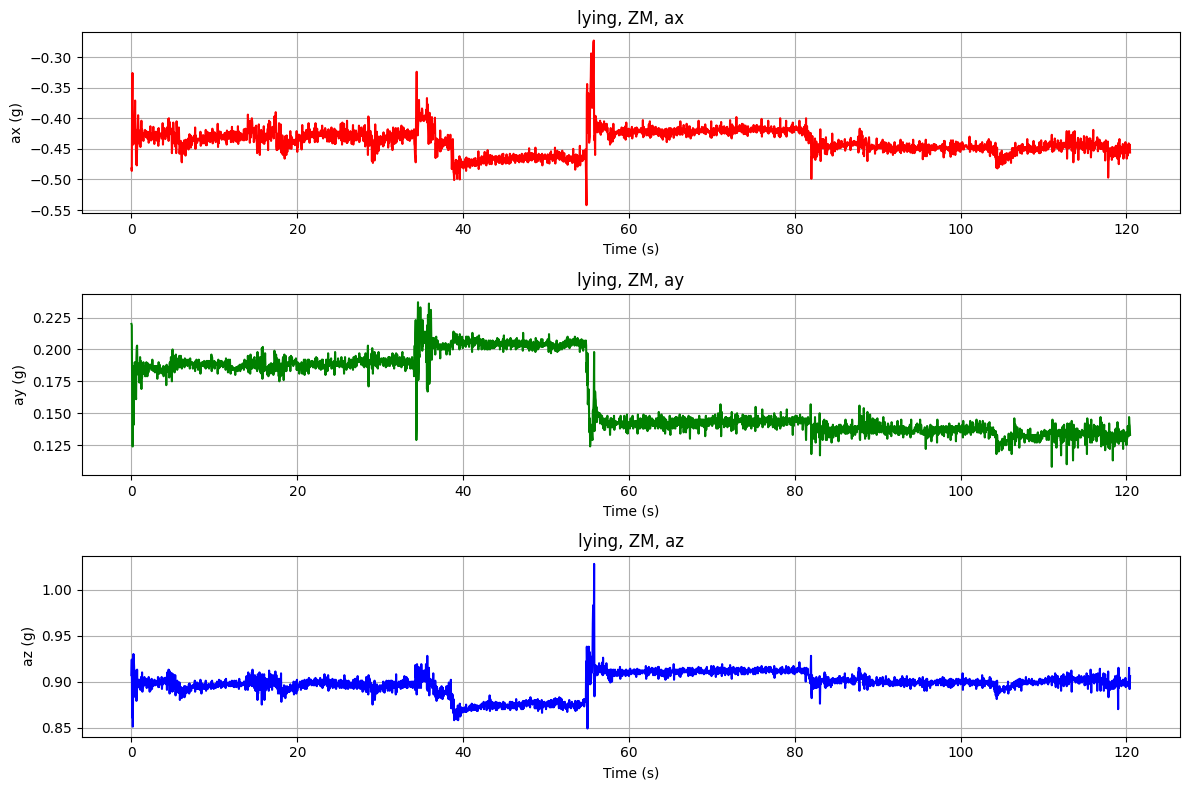

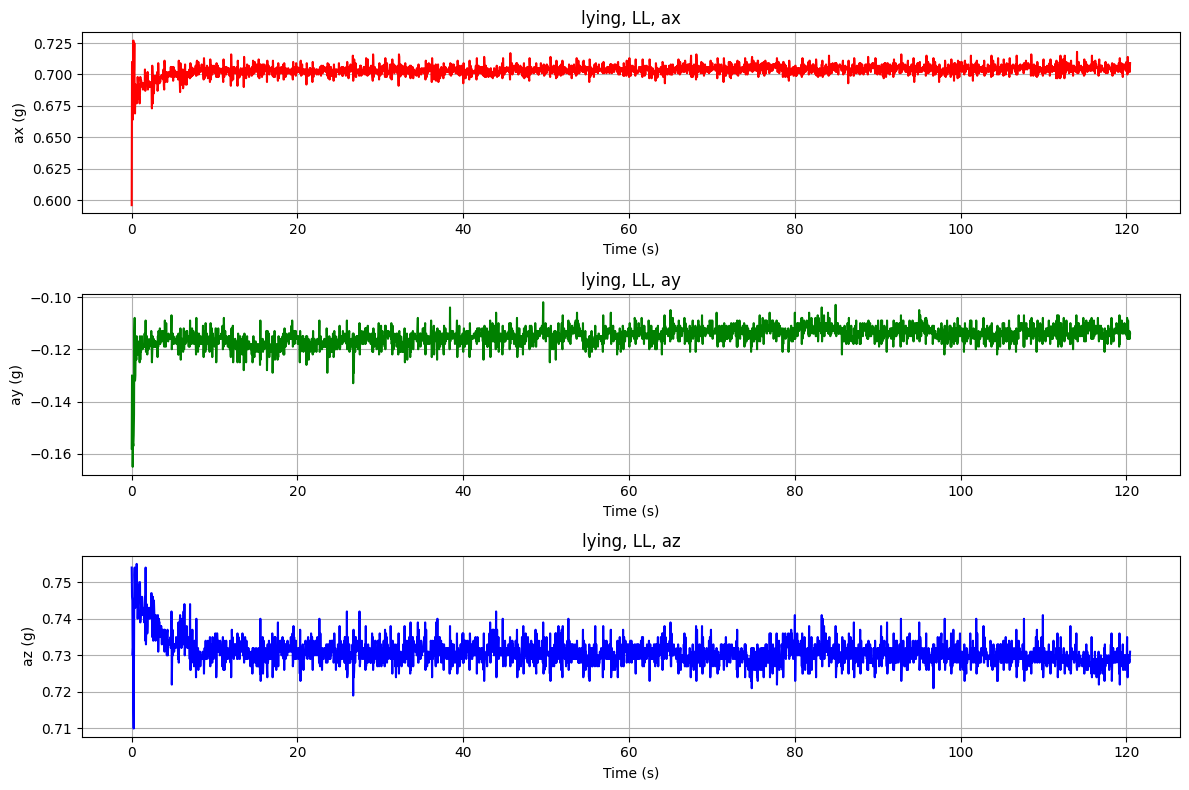

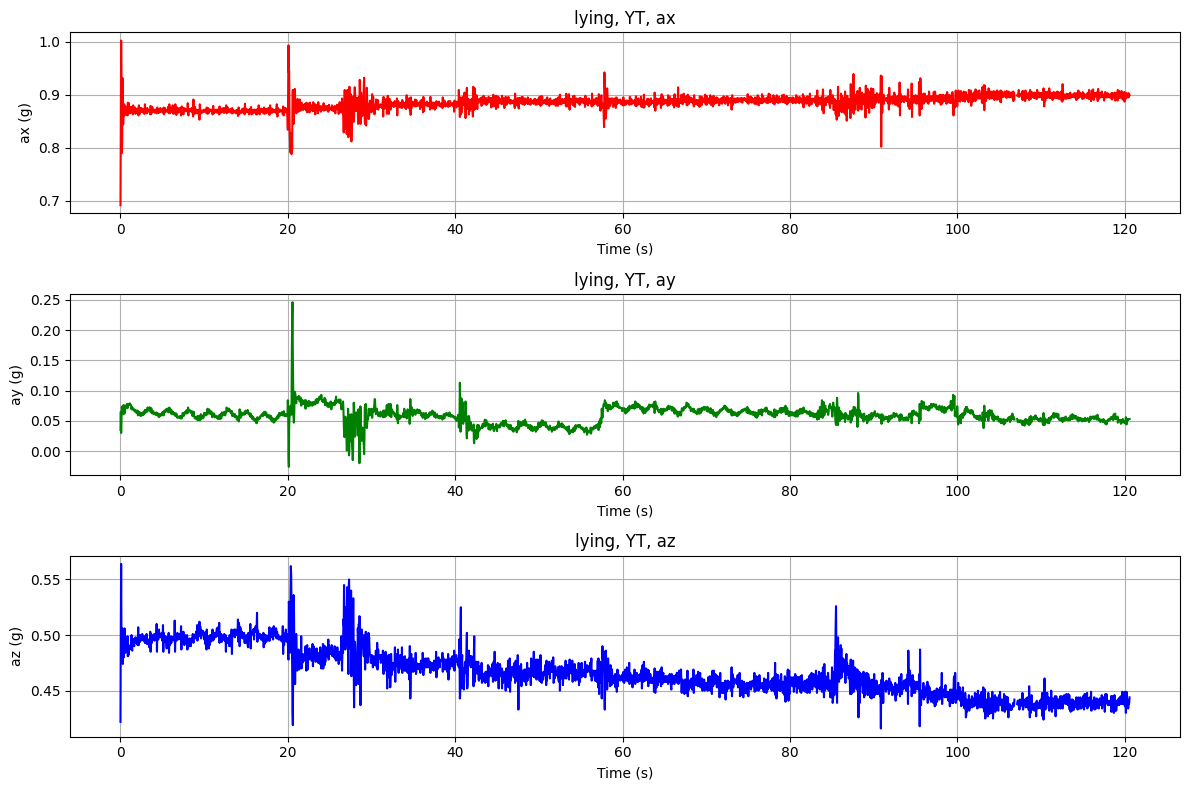

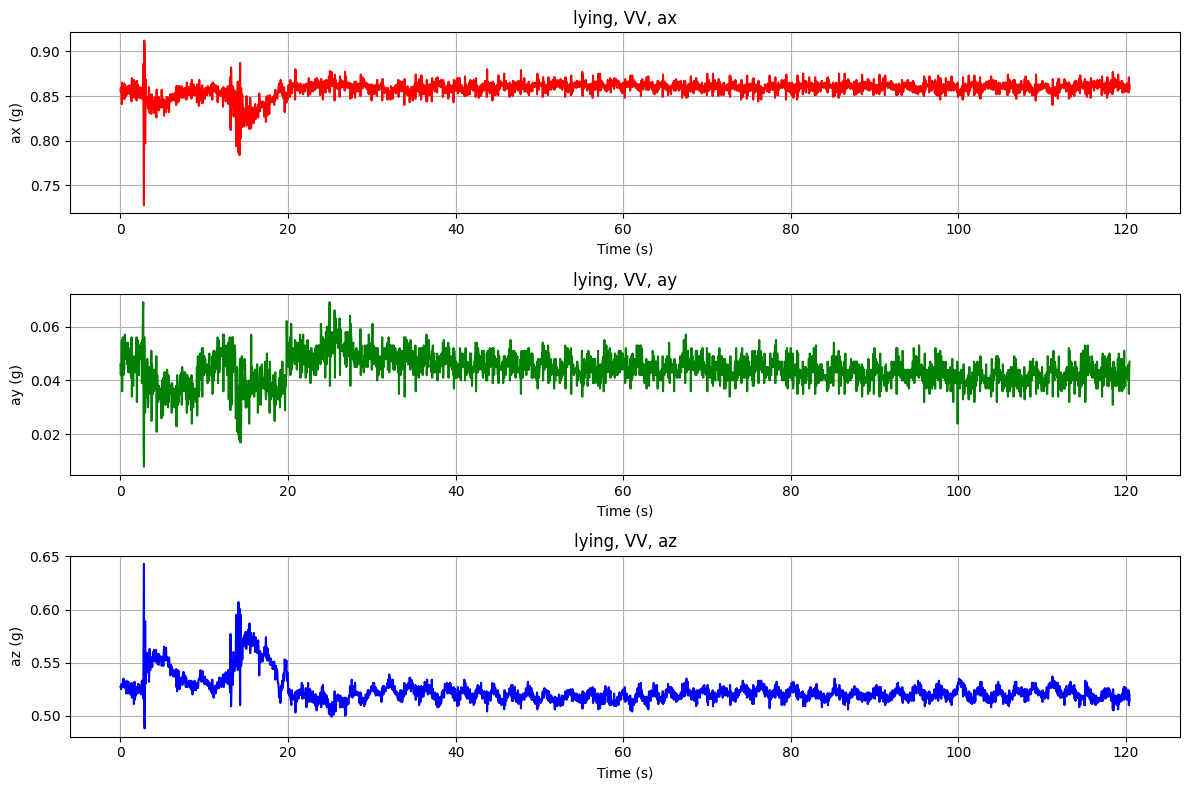

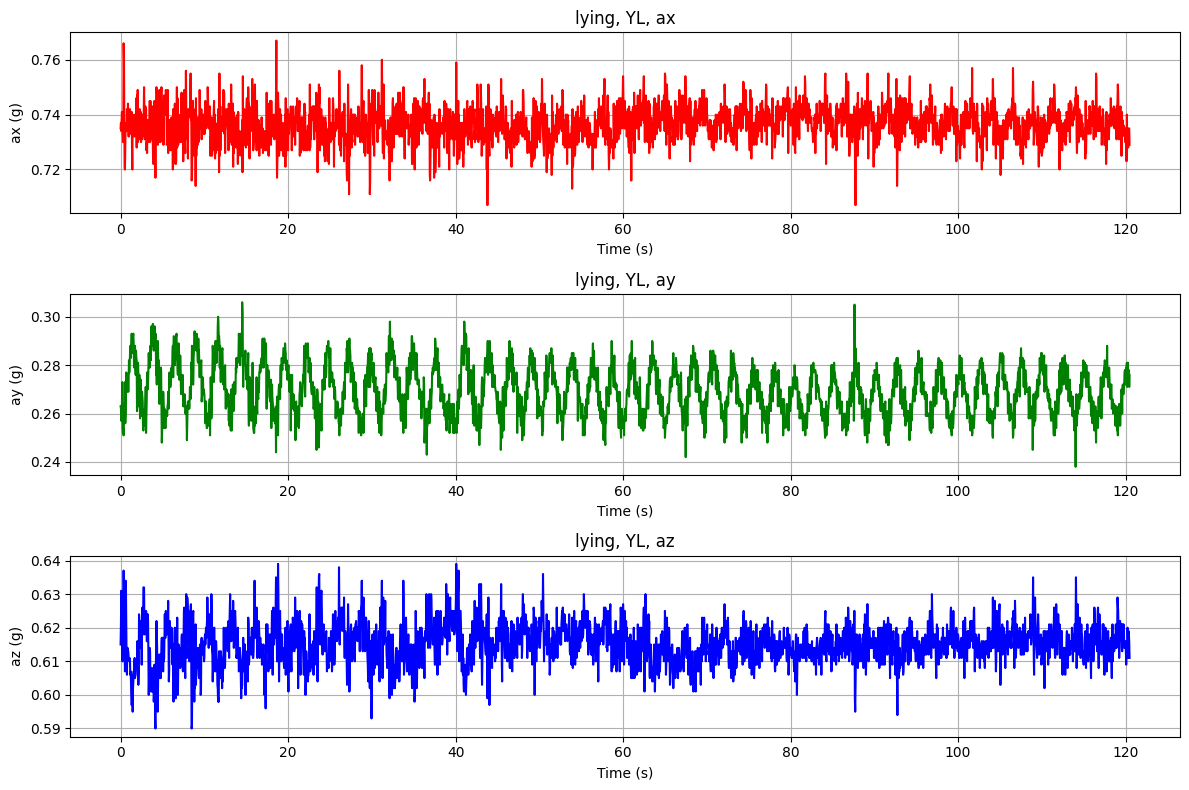

In [10]:
sampling_frequency = 25.0  # in Hz
activities = truncated_df['activity_id'].unique()
participants = truncated_df['participant_id'].unique()

for activity in activities:
    for participant in participants:
        subset = truncated_df[(truncated_df['activity_id'] == activity) & (truncated_df['participant_id'] == participant)]
        if subset.empty:
            continue
        
        time = np.arange(len(subset)) / sampling_frequency
        
        plt.figure(figsize=(12, 8))
        
        plt.subplot(3, 1, 1)
        plt.plot(time, subset['ax'], label='ax', color='r')
        plt.title(f'{activity}, {participant}, ax')
        plt.xlabel('Time (s)')
        plt.ylabel('ax (g)')
        plt.grid()
        
        plt.subplot(3, 1, 2)
        plt.plot(time, subset['ay'], label='ay', color='g')
        plt.title(f'{activity}, {participant}, ay')
        plt.xlabel('Time (s)')
        plt.ylabel('ay (g)')
        plt.grid()
        
        plt.subplot(3, 1, 3)
        plt.plot(time, subset['az'], label='az', color='b')
        plt.title(f'{activity}, {participant}, az')
        plt.xlabel('Time (s)')
        plt.ylabel('az (g)')
        plt.grid()
        
        plt.tight_layout()
        plt.show()

In [30]:
# Calculate the mean and standard deviation of ax, ay, az for each activity and participant
activity_stats = truncated_df.groupby(['activity_id', 'participant_id'])[['ax', 'ay', 'az']].agg(['mean', 'std']).reset_index()
print(activity_stats)

   activity_id participant_id        ax                  ay            \
                                   mean       std      mean       std   
0        lying             LL  0.703391  0.004779 -0.114986  0.003829   
1        lying             VV  0.858334  0.009058  0.044064  0.005596   
2        lying             YL  0.736594  0.006555  0.269467  0.010013   
3        lying             YT  0.885178  0.014211  0.059140  0.014037   
4        lying             ZM -0.438181  0.020302  0.163850  0.028892   
5      running             LL -0.451011  0.815029 -1.082308  0.996831   
6      running             VV -0.145801  0.350112 -1.108210  0.668355   
7      running             YL -0.125154  0.317559 -1.030573  0.492505   
8      running             YT  0.023483  0.580373 -1.113274  0.901714   
9      running             ZM  0.017651  0.420416  0.979569  1.150298   
10     sitting             LL  0.019372  0.077855 -1.028702  0.018170   
11     sitting             VV  0.257655  0.025147 -

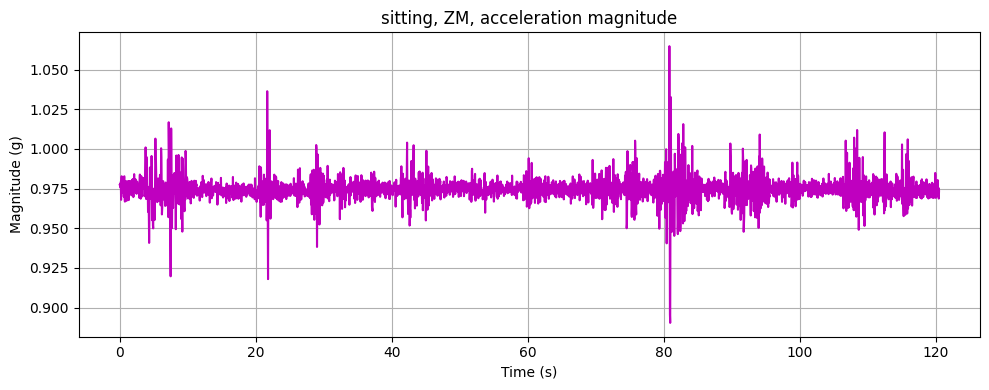

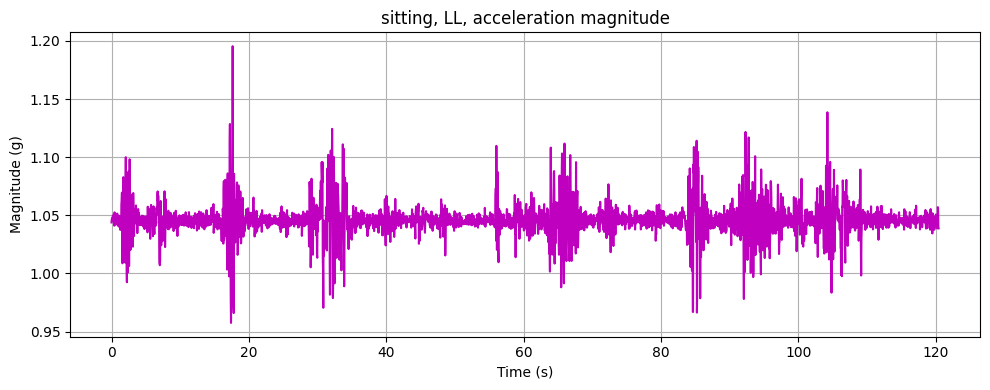

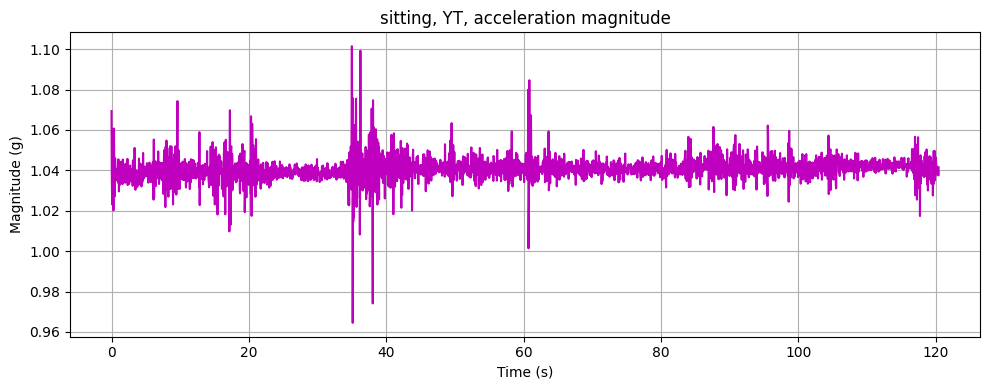

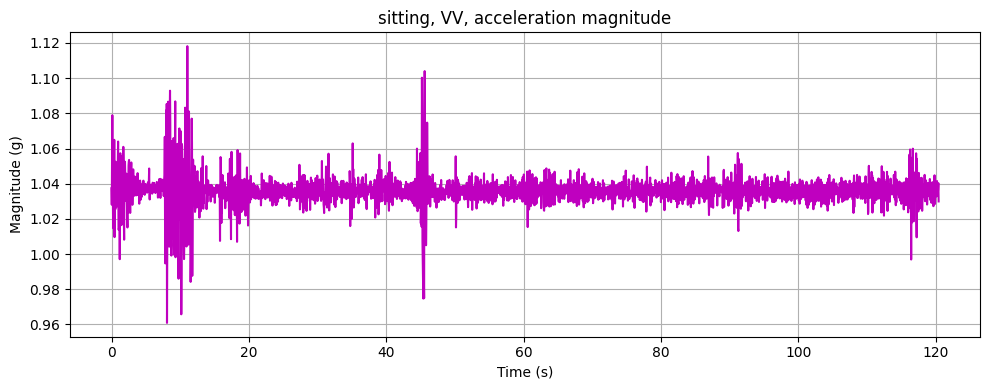

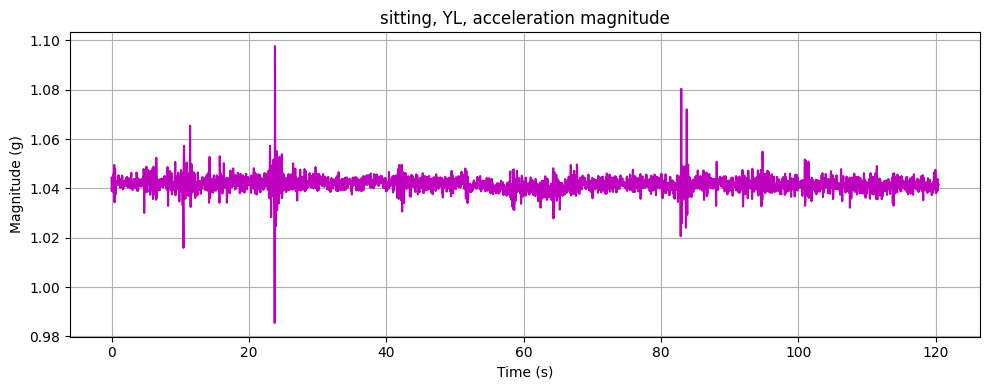

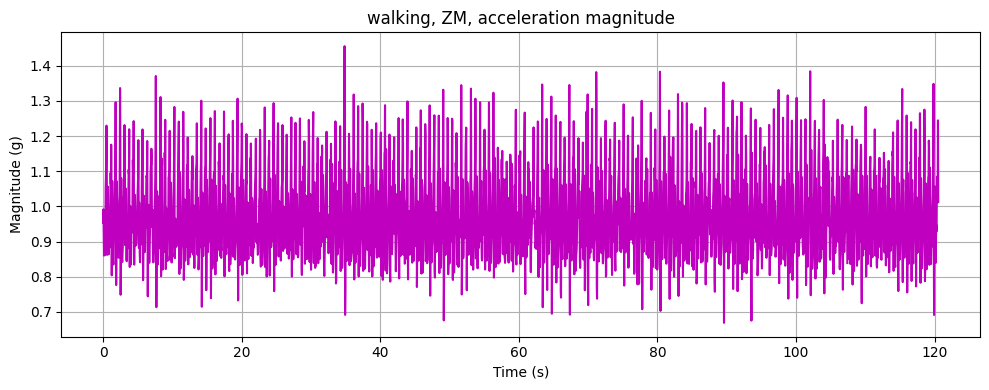

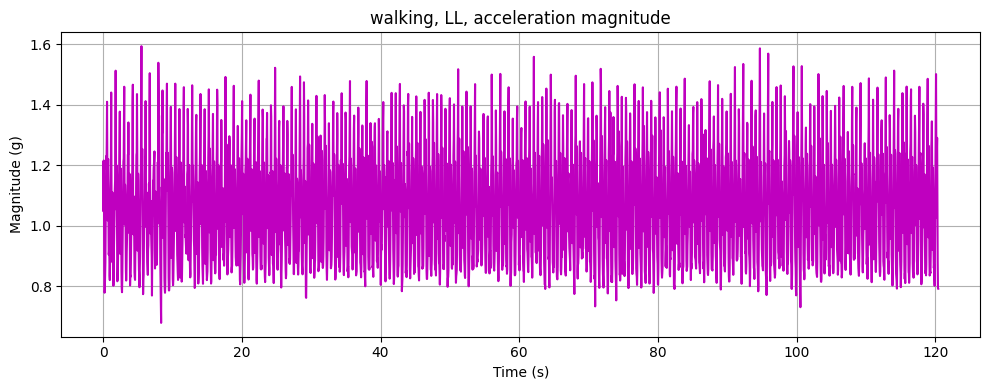

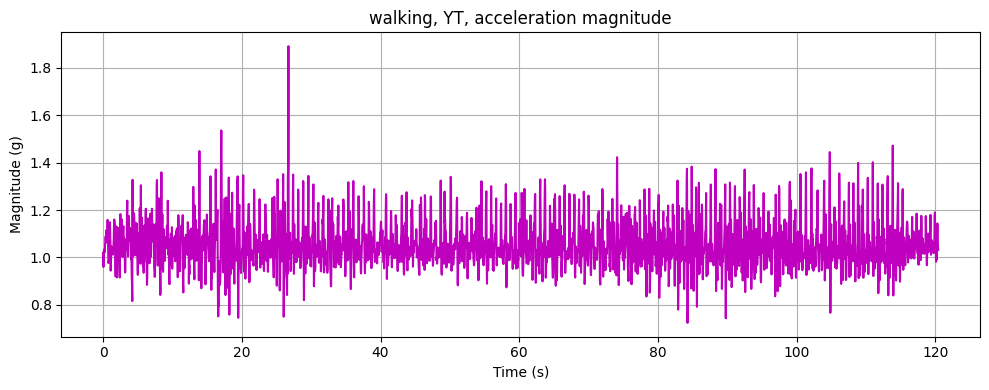

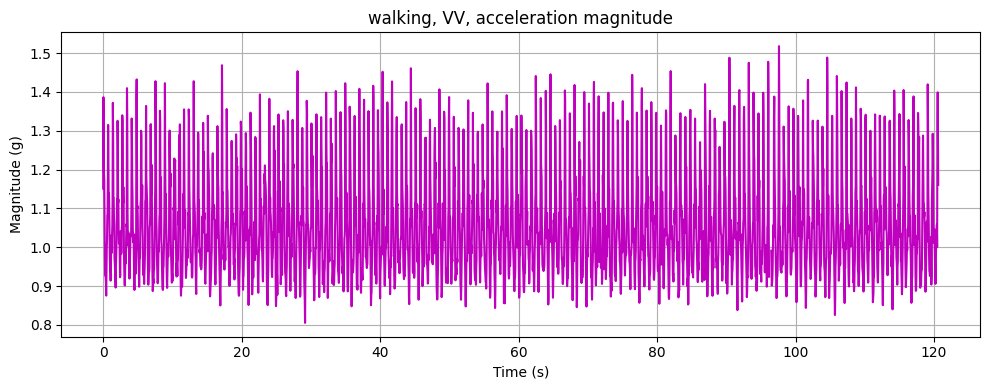

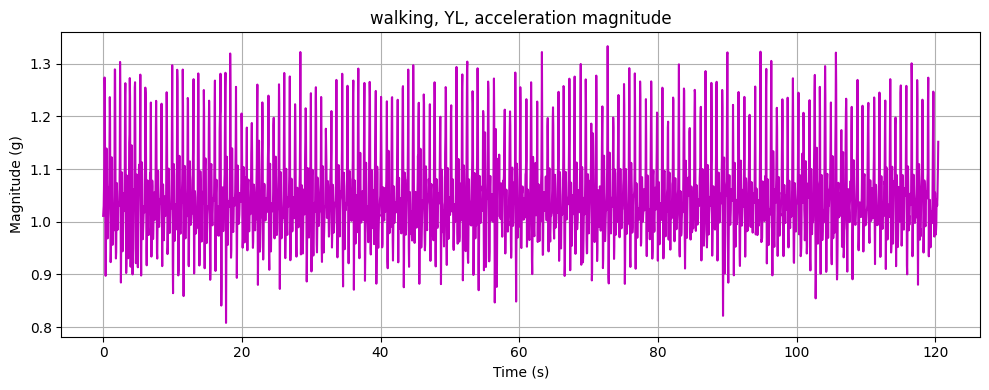

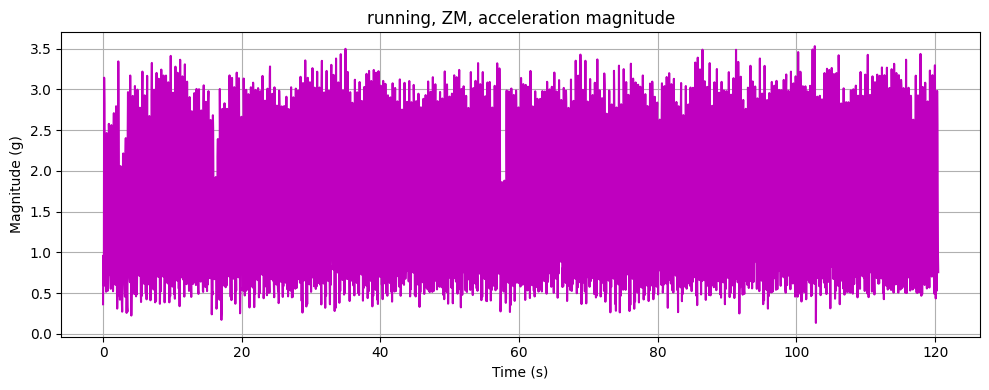

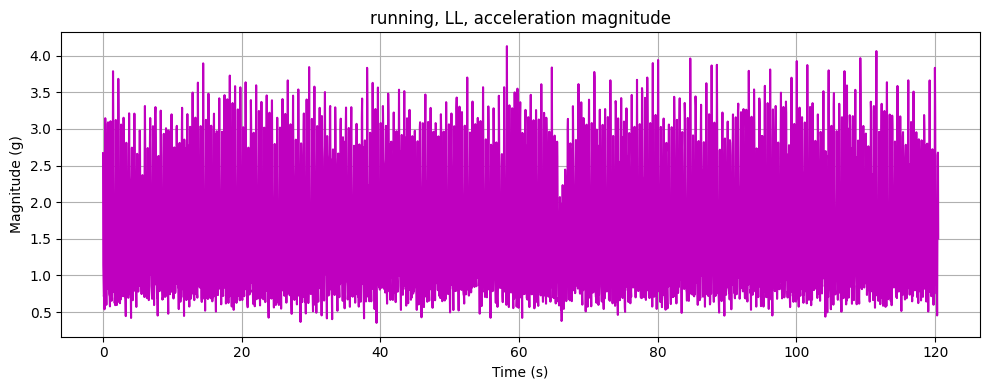

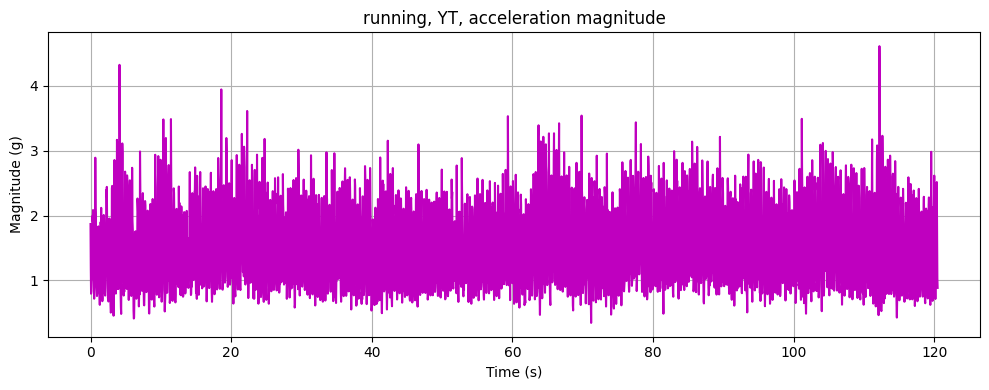

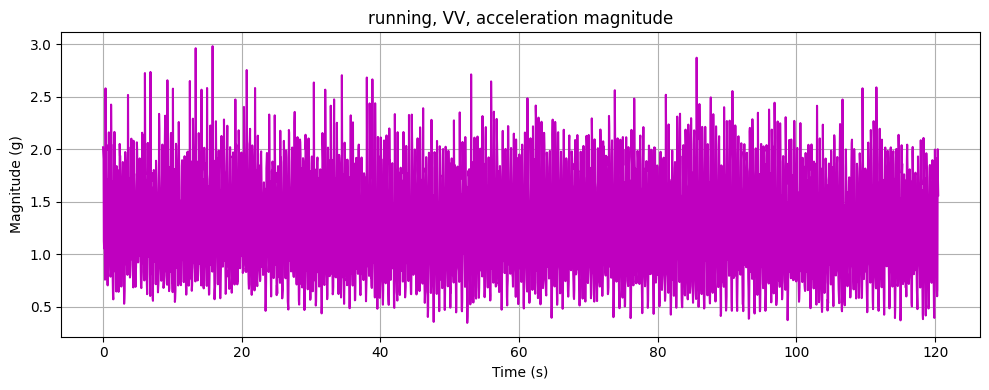

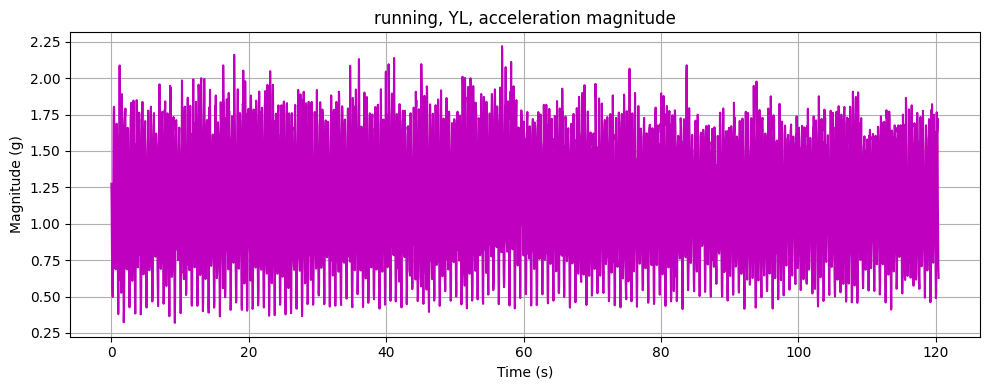

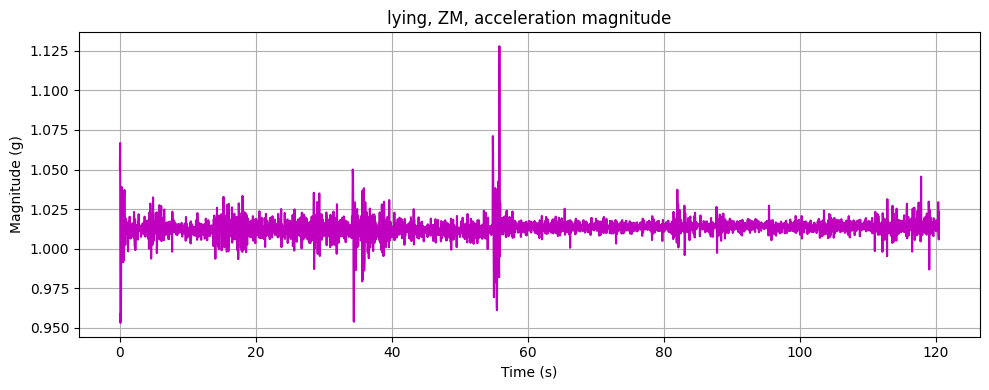

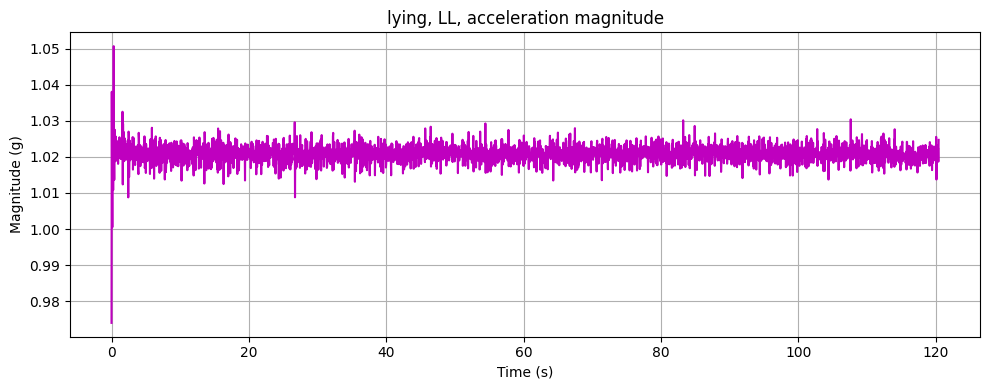

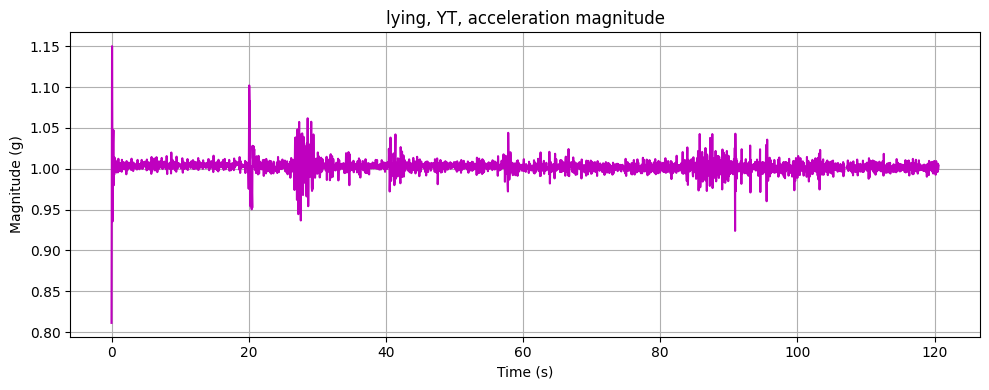

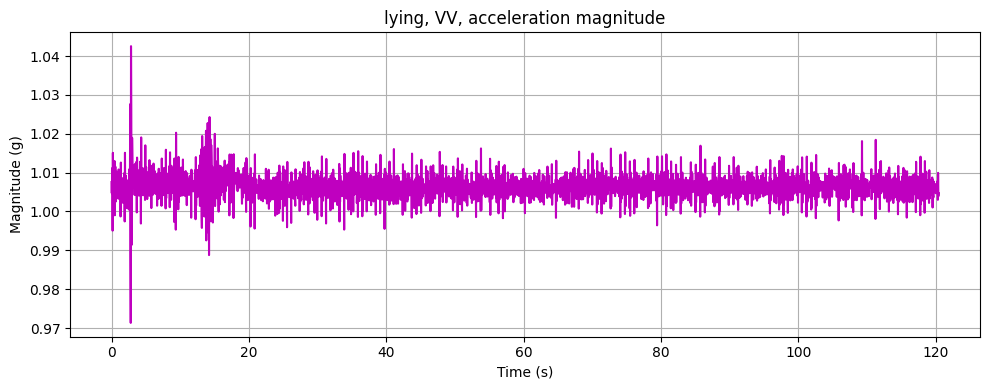

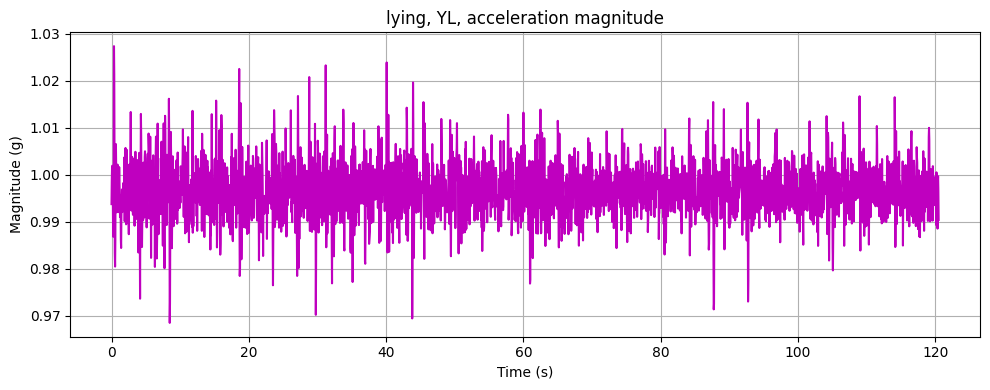

In [33]:
# Calculate and plot the magnitude of acceleration for each activity and participant
truncated_df['magnitude'] = np.sqrt(truncated_df['ax']**2 + truncated_df['ay']**2 + truncated_df['az']**2)
for activity in activities:
    for participant in participants:
        subset = truncated_df[(truncated_df['activity_id'] == activity) & (truncated_df['participant_id'] == participant)]
        if subset.empty:
            continue
        
        time = np.arange(len(subset)) / sampling_frequency
        
        plt.figure(figsize=(10, 4))
        plt.plot(time, subset['magnitude'], label='Magnitude', color='m')
        plt.title(f'{activity}, {participant}, acceleration magnitude')
        plt.xlabel('Time (s)')
        plt.ylabel('Magnitude (g)')
        plt.grid()
        plt.tight_layout()
        plt.show()

In [32]:
# Calculate the mean and standard deviation of acceleration magnitude for each activity and participant
magnitude_stats = truncated_df.groupby(['activity_id', 'participant_id'])['magnitude'].agg(['mean', 'std']).reset_index()
print(magnitude_stats)

   activity_id participant_id      mean       std
0        lying             LL  1.020891  0.002595
1        lying             VV  1.006536  0.003316
2        lying             YL  0.996842  0.005838
3        lying             YT  1.002565  0.009795
4        lying             ZM  1.013079  0.006572
5      running             LL  1.541756  0.888615
6      running             VV  1.261322  0.546409
7      running             YL  1.149813  0.460778
8      running             YT  1.448894  0.659900
9      running             ZM  1.408124  0.870328
10     sitting             LL  1.046017  0.014824
11     sitting             VV  1.035909  0.008460
12     sitting             YL  1.041689  0.003363
13     sitting             YT  1.040715  0.006113
14     sitting             ZM  0.974538  0.007977
15     walking             LL  1.059498  0.183630
16     walking             VV  1.052624  0.132305
17     walking             YL  1.048674  0.082748
18     walking             YT  1.055346  0.096671
